In [3]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp312-cp312-linux_x86_64.whl size=567861 sha256=8cf3d56e5cfff0937518c98bda85c52c5f65019247d56a686ead9b87fa17f18f
  Stored in directory: /root/.cache/pip/wheels/ab/d0/26/b82cb0f49ae73e5e6bba4e8462fff2c9851d7bd2ec64f8891e
Successfully built fastdtw


In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
COLUMN_NAMES = [
    'acc_chest_x', 'acc_chest_y', 'acc_chest_z',    # 0-2 (Chest Acc)
    'ecg_1', 'ecg_2',                               # 3-4 (ECG)
    'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z',    # 5-7 (Ankle Acc)
    'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z', # 8-10 (Ankle Gyro)
    'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z',    # 11-13 (Ankle Mag)
    'acc_arm_x', 'acc_arm_y', 'acc_arm_z',          # 14-16 (Arm Acc)
    'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z',       # 17-19 (Arm Gyro)
    'mag_arm_x', 'mag_arm_y', 'mag_arm_z',          # 20-22 (Arm Mag)
    'activity_id'                                   # 23 (Label)
]

target_activities = {
    4: 'Walking',                   # 비교군 1 (동작의 구분감)
    6: 'Waist bends forward',       # 후보 1
    7: 'Frontal elevation of arms', # 후보 2
    8: 'Knees bending',             # 후보 3
    9: 'Cycling',                   # 비교군 2 (동작 속도의 적합성)
    12: 'Jump front & back'         # 비교군 3 (단축 동작)
}

def load_mhealth_dataset(data_dir='./'):
    full_dataset = {}

    file_list = sorted(glob.glob(os.path.join(data_dir, "mHealth_subject*.log")))

    if not file_list:
        print(f"Error: No files found in directory '{data_dir}'. Check the path and file names.")
        return {}

    for file_path in file_list:
        file_name = os.path.basename(file_path)
        subj_id = file_name.split('.')[0].replace('_', '')

        df = pd.read_csv(file_path, sep="\t", header=None)
        if df.shape[1] == len(COLUMN_NAMES):
            df.columns = COLUMN_NAMES
        else:
            print(f"Warning: {subj_id} has {df.shape[1]} columns, expected {len(COLUMN_NAMES)}.")

        subj_data = {}

        for label_code, activity_name in target_activities.items():
            activity_df = df[df['activity_id'] == label_code].copy()

            if not activity_df.empty:
                subj_data[activity_name] = activity_df.drop(columns=['activity_id'])

        full_dataset[subj_id] = subj_data

    print(f"\nSuccessfully loaded data for {len(full_dataset)} subjects.")
    return full_dataset

data_directory = '/content/drive/MyDrive/Colab Notebooks/HAR_data/MHEALTHDATASET'
mhealth_data = load_mhealth_dataset(data_directory)


Successfully loaded data for 10 subjects.


# 제안 방법
Motion Difficulty Index: $MDI_{total} = w_1 \cdot S_{drift} + w_2 \cdot S_{rotation} + w_3 \cdot S_{ambiguity}$

Calculating S_drift for all subjects...
 - mHealthsubject1: 0.3810
 - mHealthsubject10: 0.1721
 - mHealthsubject2: 0.2569
 - mHealthsubject3: 0.2691
 - mHealthsubject4: 0.2606
 - mHealthsubject5: 0.3111
 - mHealthsubject6: 0.2374
 - mHealthsubject7: 0.2351
 - mHealthsubject8: 0.3122
 - mHealthsubject9: 0.1715


/tmp/ipython-input-3393364762.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Subject', y='S_drift', data=df_res, palette='Reds_r')


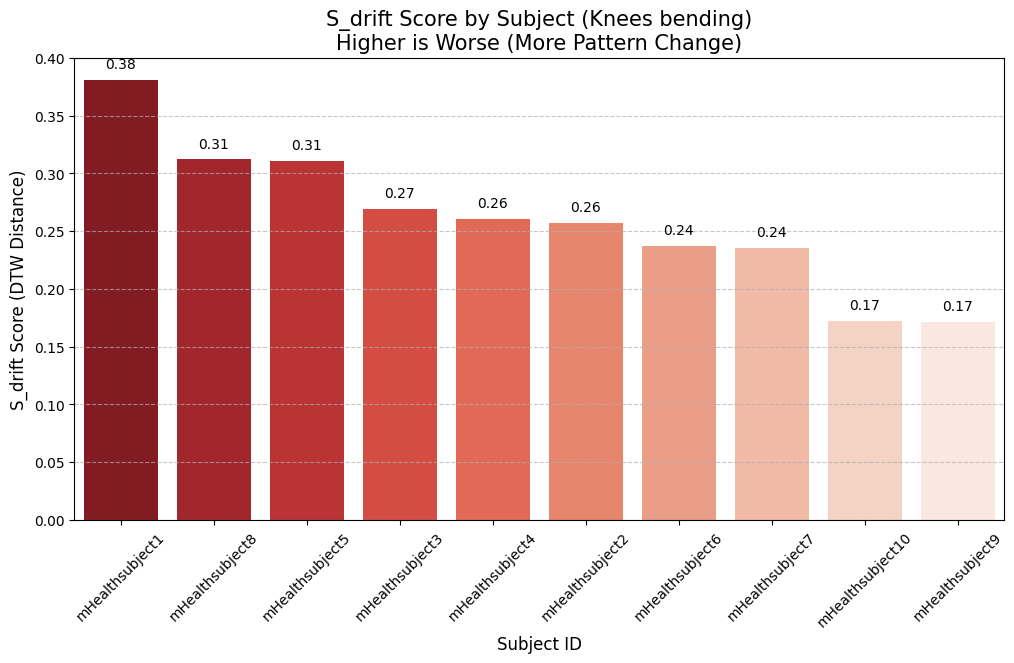

In [6]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import numpy as np

def calculate_s_drift(acc_data):
    # 1. Magnitude (움직임의 세기) 계산
    # 3축(x, y, z)을 따로 보면 복잡하니까, 힘의 총합(벡터 크기) 하나로 합쳐서 계산한다.
    mag = np.linalg.norm(acc_data, axis=1)

    # 2. 비교 구간 설정 (처음 30% vs 마지막 30%)
    # 10%는 너무 짧아서 우연히 노이즈가 섞이면 결과가 튈 수 있다.
    # 전체 데이터 길이(len)를 기준으로 자른다.
    split_idx = int(len(mag) * 0.3)

    # 3. 데이터 추출 및 형태 변환 (Reshape)
    # Q. reshape(-1, 1)을 하는 이유
    # A. fastdtw 라이브러리는 입력으로 [1, 2, 3] 같은 리스트가 아니라
    #    [[1], [2], [3]] 같은 '2차원 기둥(컬럼 벡터)' 형태를 원한다.
    #    이걸 안 하면 "1-D vector" 에러가 뜬다.
    first_part = mag[:split_idx].reshape(-1, 1)
    last_part = mag[-split_idx:].reshape(-1, 1)

    # 4. FastDTW 실행
    # dist=euclidean: 두 점 사이의 거리는 유클리드 공식으로 재라.
    # 반환값 distance: 두 그래프를 매칭시켰을 때 생기는 오차의 총합.
    # 반환값 path: 어떻게 매칭했는지 경로
    distance, path = fastdtw(first_part, last_part, dist=euclidean)

    # 5. 정규화 (Normalization)
    # 데이터 길이가 길면 당연히 distance 총합도 커진다. -> 정규화로 공정한 비교
    # 공정한 비교를 위해 '매칭된 길이(path의 길이)'로 나눠준다.
    s_drift = distance / len(path)

    return s_drift


results = []
target_activity = 'Knees bending'

print("Calculating S_drift for all subjects...")

for subj_id, activities in mhealth_data.items():
    if target_activity not in activities:
        continue

    df = activities[target_activity]

    # 발목 가속도 데이터 추출
    ankle_acc = df[['acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z']].values

    # 점수 계산
    drift_score = calculate_s_drift(ankle_acc)

    results.append({
        'Subject': subj_id,
        'S_drift': drift_score
    })
    print(f" - {subj_id}: {drift_score:.4f}")

# 데이터프레임 변환
df_res = pd.DataFrame(results)

# 점수가 높은 순(나쁜 순)으로 정렬
df_res = df_res.sort_values('S_drift', ascending=False)

# 시각화
plt.figure(figsize=(12, 6))

# 색상 팔레트: 점수가 높을수록 진한 빨강, 낮을수록 파랑/초록
sns.barplot(x='Subject', y='S_drift', data=df_res, palette='Reds_r')

plt.title(f'S_drift Score by Subject ({target_activity})\nHigher is Worse (More Pattern Change)', fontsize=15)
plt.xticks(rotation=45)
plt.ylabel('S_drift Score (DTW Distance)', fontsize=12)
plt.xlabel('Subject ID', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 막대 위에 점수 표시
for i, v in enumerate(df_res['S_drift']):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)

plt.show()

Calculating S_rotation for all subjects...
 - mHealthsubject1: 0.1069
 - mHealthsubject10: 0.0430
 - mHealthsubject2: 0.1205
 - mHealthsubject3: 0.0848
 - mHealthsubject4: 0.1459
 - mHealthsubject5: 0.0712
 - mHealthsubject6: 0.0639
 - mHealthsubject7: 0.0418
 - mHealthsubject8: 0.1468
 - mHealthsubject9: 0.0724


/tmp/ipython-input-4167800685.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Subject', y='S_rotation', data=df_rot, palette='Oranges_r')


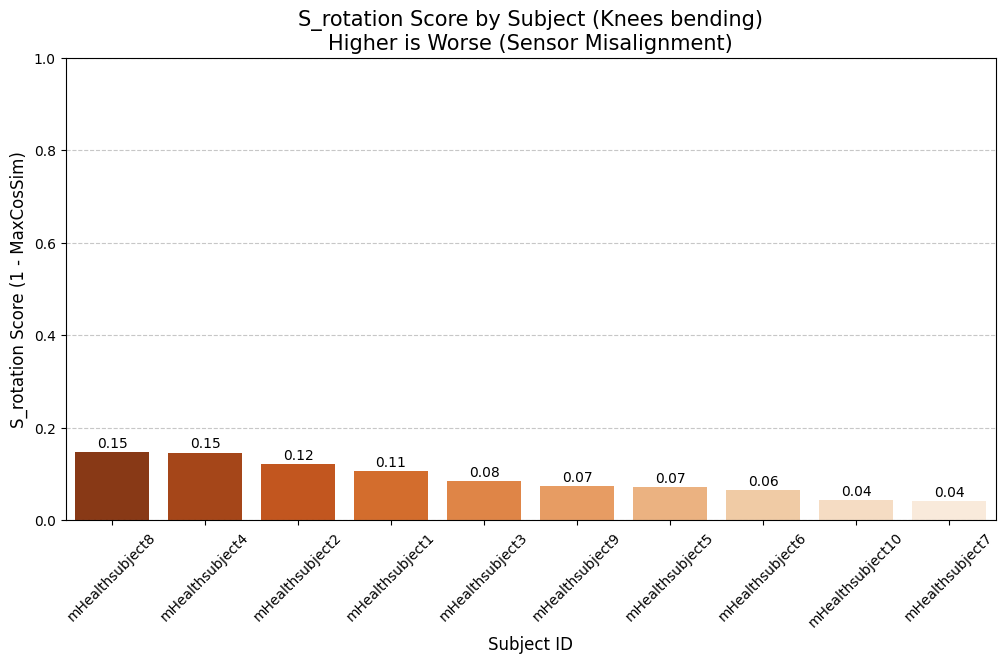

In [8]:
from sklearn.decomposition import PCA
import numpy as np

def calculate_s_rotation(acc_data):
    # 1. PCA 모델 준비 (가장 센 성분 1개만 찾겠다)
    pca = PCA(n_components=1)

    # 2. 데이터 학습 (주성분 찾기)
    # acc_data: (N, 3) -> X, Y, Z 데이터 덩어리
    pca.fit(acc_data)

    # 3. 주성분 벡터 추출 (Principal Component)
    # pc1: [0.1, 0.9, 0.05] 처럼 생긴 벡터.
    # "운동의 90%가 Y축 방향이고, 나머지가 조금 섞였다"는 뜻.
    pc1 = pca.components_[0]

    # 4. 기준축 정의 (X, Y, Z)
    # 센서가 가질 수 있는 완벽한 방향들
    axes = np.array([
        [1, 0, 0],  # X축
        [0, 1, 0],  # Y축
        [0, 0, 1]   # Z축
    ])

    # 5. 유사도 계산 (내적 / Dot Product)
    # 주성분(pc1)이 각 축(X, Y, Z)과 얼마나 닮았는지 계산
    # np.dot 결과값: 1이면 평행(완벽), 0이면 수직(무관).
    # np.abs를 하는 이유: 벡터가 [0, -1, 0]이어도(반대 방향) 축은 일치하는 것이니 절대값
    similarities = np.abs(np.dot(axes, pc1))

    # 6. 점수 계산
    '''
    유사도를 에러로 바꿔주기 위한 과정
    EX)
        1. 정석대로 완벽한 사람
            - 유사도 = 0.99
            - Score = 1-0.99=0.01

        2. 완벽하지 않은 사람
            - 유사도 = 0.70
            - Score = 1-0.70=0.30
    '''
    s_rotation = 1 - np.max(similarities)  # np.max를 사용하는 이유 -> 길어서 Notion에 정리

    return s_rotation


results_rot = []
target_activity = 'Knees bending'

print("Calculating S_rotation for all subjects...")

for subj_id, activities in mhealth_data.items():
    if target_activity not in activities:
        continue

    df = activities[target_activity]

    # 발목 Acc 사용
    ankle_acc = df[['acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z']].values

    # 점수 계산
    rot_score = calculate_s_rotation(ankle_acc)

    results_rot.append({
        'Subject': subj_id,
        'S_rotation': rot_score
    })
    print(f" - {subj_id}: {rot_score:.4f}")

# 데이터프레임 변환 및 정렬
df_rot = pd.DataFrame(results_rot)
df_rot = df_rot.sort_values('S_rotation', ascending=False)

# 시각화
plt.figure(figsize=(12, 6))

# 점수가 높을수록(나쁠수록) 진한 주황색
sns.barplot(x='Subject', y='S_rotation', data=df_rot, palette='Oranges_r')

plt.title(f'S_rotation Score by Subject ({target_activity})\nHigher is Worse (Sensor Misalignment)', fontsize=15)
plt.xticks(rotation=45)
plt.ylabel('S_rotation Score (1 - MaxCosSim)', fontsize=12)
plt.xlabel('Subject ID', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.0) # 코사인 유사도 오차 범위는 0~1 사이

for i, v in enumerate(df_rot['S_rotation']):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)

plt.show()

Building Multi-class Dataset...
Dataset Ready: (1193, 150) samples
Calculating S_ambiguity (Standard Multi-class Entropy)...
 - mHealthsubject1: 0.1861
 - mHealthsubject10: 0.1136
 - mHealthsubject2: 0.1326
 - mHealthsubject3: 0.1961
 - mHealthsubject4: 0.2499
 - mHealthsubject5: 0.1731
 - mHealthsubject6: 0.2194
 - mHealthsubject7: 0.1826
 - mHealthsubject8: 0.1083
 - mHealthsubject9: 0.0812


/tmp/ipython-input-2107372728.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Subject', y='S_ambiguity', data=df_amb, palette='Purples_r')


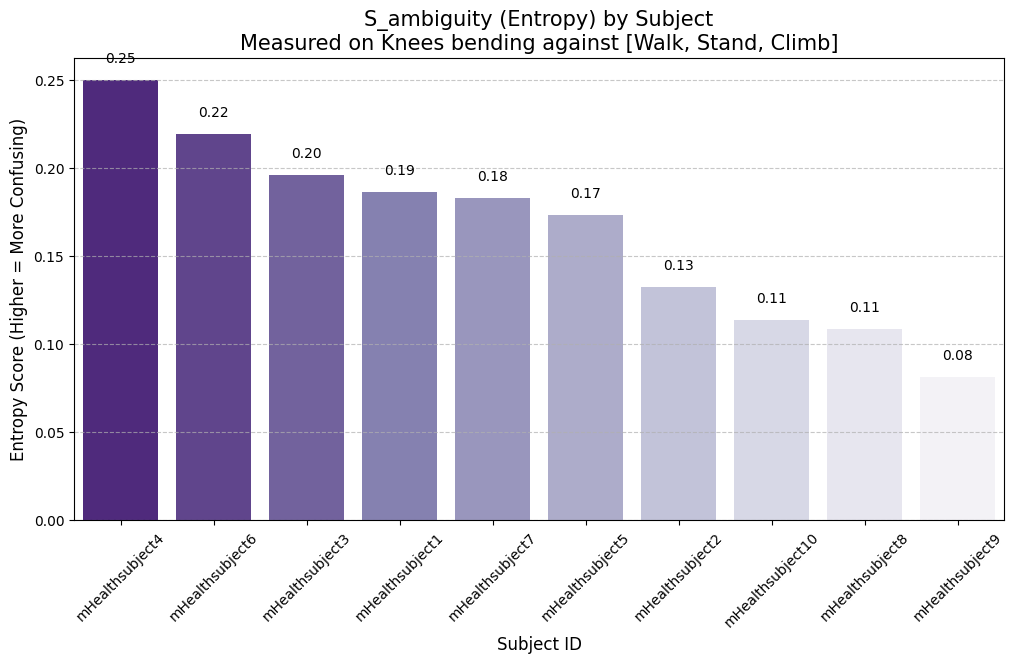

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import entropy

# =========================================================
# 1. 설정: 비교할 동작 리스트 (Confusion을 유발할 동작들)
# =========================================================
# 스쿼트가 얼마나 이 동작들과 구분되는지(Distinctiveness)를 본다.
activity_list = ['Knees bending', 'Walking', 'Standing', 'Climbing stairs up']
target_act = 'Knees bending' # 우리가 점수를 매길 동작

# =========================================================
# 2. 특징 추출 함수 (간결하게 통계값만)
# =========================================================
def extract_raw_features(df):
    # 가속도 3축만 사용
    acc_data = df[['acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z']].values

    # 데이터가 너무 길면 1초(50샘플) 단위로 잘라서 특징 추출
    window_size = 50
    features = []

    for i in range(0, len(acc_data) - window_size, window_size):
        segment = acc_data[i:i+window_size]

        f = segment.flatten()
        features.append(f)

    return np.array(features)

# =========================================================
# 3. 데이터셋 구축 (전체 피험자, 전체 동작)
# =========================================================
print("Building Multi-class Dataset...")

X_total = []
y_total = [] # 동작 라벨 (0: Squat, 1: Walk, ...)
s_total = [] # 피험자 ID

act_to_id = {name: i for i, name in enumerate(activity_list)}

for subj_id, acts in mhealth_data.items():
    for act_name in activity_list:
        if act_name not in acts: continue

        # 특징 추출
        feats = extract_raw_features(acts[act_name])

        if len(feats) == 0: continue

        X_total.append(feats)
        # 라벨은 동작 ID
        y_total.append(np.full(len(feats), act_to_id[act_name]))
        # 피험자 ID 저장 (나중에 Leave-One-Out 할 때 씀)
        s_total.append(np.full(len(feats), subj_id))

# 리스트를 하나의 거대한 넘파이 배열로 병합
X_total = np.concatenate(X_total)
y_total = np.concatenate(y_total)
s_total = np.concatenate(s_total)

print(f"Dataset Ready: {X_total.shape} samples")

# =========================================================
# 4. S_ambiguity 계산 (Leave-One-Subject-Out)
# =========================================================
results_amb = []
unique_subjs = np.unique(s_total)

print("Calculating S_ambiguity (Standard Multi-class Entropy)...")

for target_subj in unique_subjs:
    # -----------------------------------------------------
    # A. 훈련 데이터: 타겟 피험자 제외한 나머지 사람들의 '모든 동작'
    # -----------------------------------------------------
    train_mask = (s_total != target_subj)
    X_train = X_total[train_mask]
    y_train = y_total[train_mask]

    # -----------------------------------------------------
    # B. 테스트 데이터: 타겟 피험자의 'Knees bending' 만!
    # -----------------------------------------------------
    # 우리는 "이 사람의 스쿼트가 얼마나 헷갈리는지"만 궁금함
    test_mask = (s_total == target_subj) & (y_total == act_to_id[target_act])
    X_test = X_total[test_mask]

    if len(X_test) == 0: continue # 데이터 없으면 패스

    # -----------------------------------------------------
    # C. 모델 학습 (Random Forest)
    # -----------------------------------------------------
    clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)

    # -----------------------------------------------------
    # D. 예측 및 엔트로피 계산
    # -----------------------------------------------------
    # predict_proba: [스쿼트확률, 걷기확률, 서기확률, 계단확률]
    probs = clf.predict_proba(X_test)

    # 엔트로피 계산 (각 샘플별)
    # 분포가 [1.0, 0, 0, 0] 이면 엔트로피 0 (명확)
    # 분포가 [0.25, 0.25, 0.25, 0.25] 면 엔트로피 최대 (모호)
    ent_values = entropy(probs.T)

    # 평균 엔트로피가 이 사람의 최종 S_ambiguity 점수
    mean_ent = np.mean(ent_values)

    results_amb.append({
        'Subject': target_subj,
        'S_ambiguity': mean_ent
    })
    print(f" - {target_subj}: {mean_ent:.4f}")

# =========================================================
# 5. 시각화
# =========================================================
df_amb = pd.DataFrame(results_amb).sort_values('S_ambiguity', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Subject', y='S_ambiguity', data=df_amb, palette='Purples_r')
plt.title(f'S_ambiguity (Entropy) by Subject\nMeasured on {target_act} against [Walk, Stand, Climb]', fontsize=15)
plt.xticks(rotation=45)
plt.ylabel('Entropy Score (Higher = More Confusing)', fontsize=12)
plt.xlabel('Subject ID', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(df_amb['S_ambiguity']):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)

plt.show()

=== MDI Final Ranking (Top is Worst Quality / LQ) ===
         S_drift  S_rotation  S_ambiguity  Total_Rank_Sum
Subject                                                  
S4        0.2606      0.1459       0.2499            25.0
S1        0.3810      0.1069       0.1861            24.0
S8        0.3122      0.1468       0.1083            21.0
S3        0.2691      0.0848       0.1961            21.0
S2        0.2569      0.1205       0.1326            17.0
S5        0.3111      0.0712       0.1731            17.0
S6        0.2374      0.0639       0.2194            16.0
S7        0.2351      0.0418       0.1826            10.0
S9        0.1715      0.0724       0.0812             7.0
S10       0.1721      0.0430       0.1136             7.0


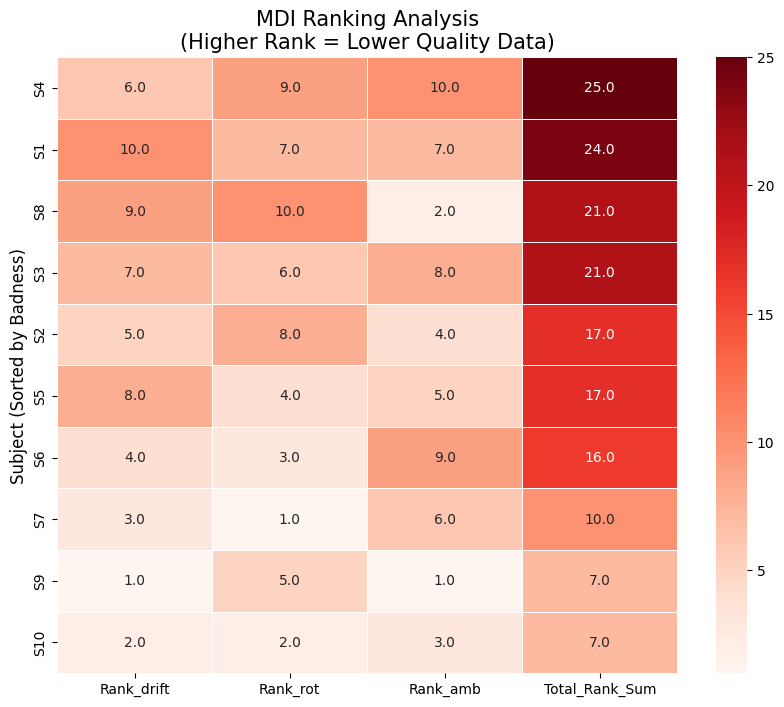


[Conclusion]
🔴 Worst Subject (LQ Candidate): S4 (Score Sum: 25.0)
🟢 Best Subject (HQ Candidate): S10 (Score Sum: 7.0)


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 보내주신 결과 데이터 입력
data = {
    'Subject': ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10'],
    'S_drift': [0.3810, 0.2569, 0.2691, 0.2606, 0.3111, 0.2374, 0.2351, 0.3122, 0.1715, 0.1721],
    'S_rotation': [0.1069, 0.1205, 0.0848, 0.1459, 0.0712, 0.0639, 0.0418, 0.1468, 0.0724, 0.0430],
    'S_ambiguity': [0.1861, 0.1326, 0.1961, 0.2499, 0.1731, 0.2194, 0.1826, 0.1083, 0.0812, 0.1136]
}

df = pd.DataFrame(data)
df = df.set_index('Subject')

# 2. Rank 계산 (점수가 높을수록 나쁜 데이터 -> 높은 랭크 부여)
# method='min'은 동점자 처리 방식 중 하나인데, 여기선 소수점이 달라 동점은 없을듯 합니다.
# ascending=True: 값이 작으면 1등(좋음), 값이 크면 10등(나쁨)
df['Rank_drift'] = df['S_drift'].rank(ascending=True)
df['Rank_rot'] = df['S_rotation'].rank(ascending=True)
df['Rank_amb'] = df['S_ambiguity'].rank(ascending=True)

# 3. Total Rank Sum 계산 (높을수록 안좋음)
df['Total_Rank_Sum'] = df['Rank_drift'] + df['Rank_rot'] + df['Rank_amb']

# 4. 최종 순위 정렬 (Total Rank Sum이 높은 순서대로 -> 즉, LQ가 맨 위로 오게)
df_sorted = df.sort_values('Total_Rank_Sum', ascending=False)

# 5. 결과 출력
print("=== MDI Final Ranking (Top is Worst Quality / LQ) ===")
print(df_sorted[['S_drift', 'S_rotation', 'S_ambiguity', 'Total_Rank_Sum']])

# 6. 시각화 (히트맵으로 한눈에 보기)
plt.figure(figsize=(10, 8))

# 랭크 데이터만 뽑아서 시각화 (높을수록 진한 색 = 나쁨)
rank_cols = ['Rank_drift', 'Rank_rot', 'Rank_amb', 'Total_Rank_Sum']
sns.heatmap(df_sorted[rank_cols], annot=True, fmt='.1f', cmap='Reds', linewidths=.5)

plt.title('MDI Ranking Analysis\n(Higher Rank = Lower Quality Data)', fontsize=15)
plt.ylabel('Subject (Sorted by Badness)', fontsize=12)
plt.show()

# 7. LQ와 HQ 선정
lq_subject = df_sorted.index[0] # 꼴찌 (가장 나쁜 데이터)
hq_subject = df_sorted.index[-1] # 일등 (가장 좋은 데이터)

print(f"\n[Conclusion]")
print(f"🔴 Worst Subject (LQ Candidate): {lq_subject} (Score Sum: {df_sorted.iloc[0]['Total_Rank_Sum']})")
print(f"🟢 Best Subject (HQ Candidate): {hq_subject} (Score Sum: {df_sorted.iloc[-1]['Total_Rank_Sum']})")

# “DualAdaptive”에 나온 방법

Calculating Method #1: Variance (Target: Knees bending)...
 - mHealthsubject1: 0.7067
 - mHealthsubject10: 0.1335
 - mHealthsubject2: 0.3671
 - mHealthsubject3: 0.3790
 - mHealthsubject4: 0.4445
 - mHealthsubject5: 0.5944
 - mHealthsubject6: 0.3568
 - mHealthsubject7: 0.2502
 - mHealthsubject8: 0.4650
 - mHealthsubject9: 0.1545


/tmp/ipython-input-396025047.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Subject', y='Variance_Score', data=df_prof1, palette='Greens_r')


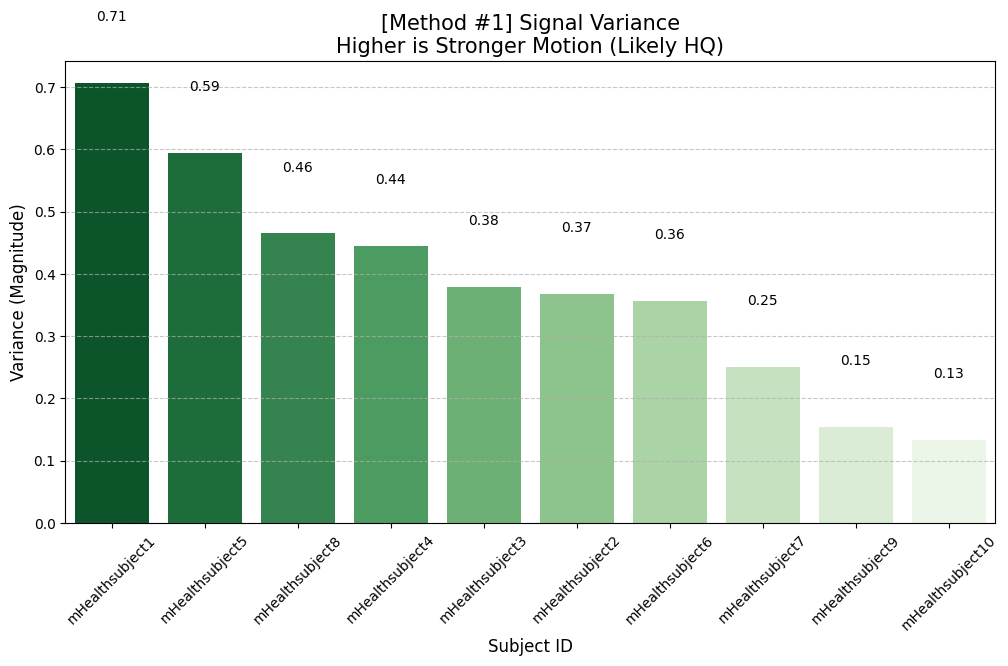


[Selection based on Variance]
🟢 Best Motion (Highest Variance): mHealthsubject1
🔴 Weak Motion (Lowest Variance): mHealthsubject10


In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# =========================================================
# 1. 분산(Variance) 계산 함수
# =========================================================
def calculate_variance_score(df):
    # 1. 3축 데이터 가져오기
    acc_data = df[['acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z']].values

    # 2. 벡터 크기(Magnitude) 계산 (중력 방향 무시하고 '움직임의 크기'만 보기 위해)
    # VM (Vector Magnitude) = sqrt(x^2 + y^2 + z^2)
    vm = np.linalg.norm(acc_data, axis=1)

    # 3. 분산 계산 (움직임의 격렬함 측정)
    # 움직임이 클수록 값이 큼
    var_score = np.var(vm)

    return var_score

# =========================================================
# 2. 전체 피험자 분석
# =========================================================
target_act = 'Knees bending'
prof_results_1 = []

print(f"Calculating Method #1: Variance (Target: {target_act})...")

for subj_id, acts in mhealth_data.items():
    if target_act not in acts: continue

    score = calculate_variance_score(acts[target_act])

    prof_results_1.append({
        'Subject': subj_id,
        'Variance_Score': score
    })
    print(f" - {subj_id}: {score:.4f}")

# =========================================================
# 3. 결과 시각화
# =========================================================
# 여기서는 점수가 높을수록(움직임이 클수록) HQ라고 가정
df_prof1 = pd.DataFrame(prof_results_1).sort_values('Variance_Score', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Subject', y='Variance_Score', data=df_prof1, palette='Greens_r')
plt.xticks(rotation=45)
plt.title(f"[Method #1] Signal Variance\nHigher is Stronger Motion (Likely HQ)", fontsize=15)
plt.ylabel('Variance (Magnitude)', fontsize=12)
plt.xlabel('Subject ID', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(df_prof1['Variance_Score']):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center', fontsize=10)

plt.show()

# 4. 교수님 기준 HQ / LQ 선정
print(f"\n[Selection based on Variance]")
print(f"🟢 Best Motion (Highest Variance): {df_prof1.iloc[0]['Subject']}")
print(f"🔴 Weak Motion (Lowest Variance): {df_prof1.iloc[-1]['Subject']}")

Calculating Method #2: Auto-correlation (Target: Knees bending)...
 - mHealthsubject1: 0.0776
 - mHealthsubject10: 0.2799
 - mHealthsubject2: 0.1152
 - mHealthsubject3: 0.1580
 - mHealthsubject4: 0.1458
 - mHealthsubject5: 0.1210
 - mHealthsubject6: 0.1165
 - mHealthsubject7: 0.1690
 - mHealthsubject8: 0.1945
 - mHealthsubject9: 0.2480


/tmp/ipython-input-301197671.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Subject', y='Autocorr_Score', data=df_prof2, palette='Blues_r')


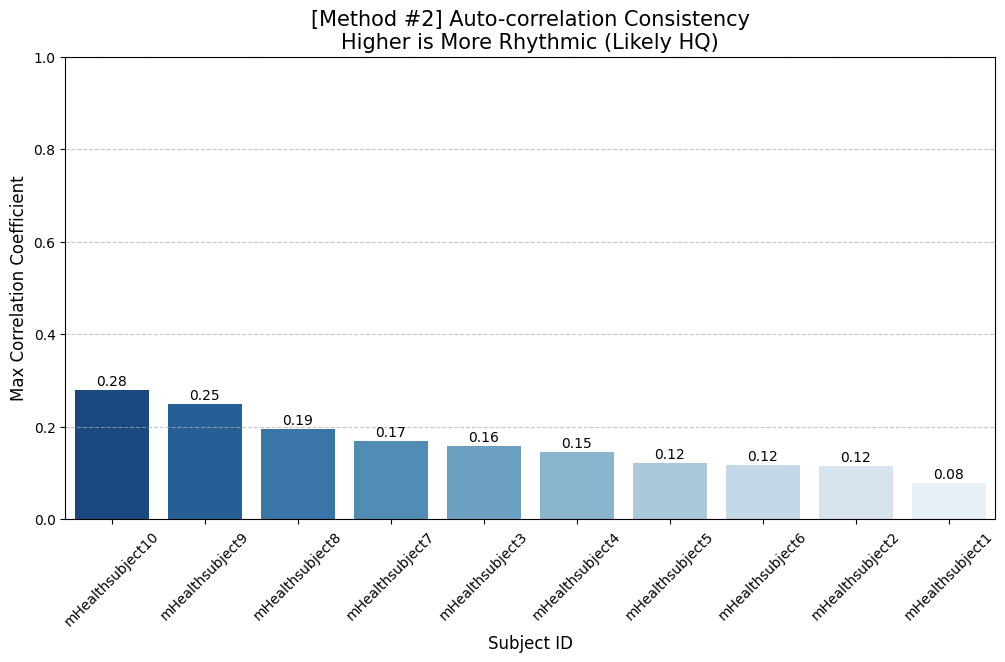

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import correlate, find_peaks

# =========================================================
# 1. Auto-correlation 점수 계산 함수
# =========================================================
def calculate_autocorr_score(df):
    # 벡터 크기(VM) 사용 (방향 무시하고 리듬만 보기 위해)
    acc_data = df[['acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z']].values
    vm = np.linalg.norm(acc_data, axis=1)

    # 1. DC 성분 제거 (평균을 0으로 맞춰야 상관계수가 제대로 나옴)
    vm_centered = vm - np.mean(vm)

    # 2. 자기상관 수행 (Full mode)
    # correlate 결과는 [-lag, ... , 0, ... +lag] 형태로 나옴
    corr = correlate(vm_centered, vm_centered, mode='full')

    # 3. 절반만 취함 (Lag >= 0 인 부분)
    corr = corr[len(corr)//2:]

    # 4. 정규화 (Lag 0일 때 1.0이 되도록)
    if corr[0] == 0: return 0.0
    corr_norm = corr / corr[0]

    # 5. 피크 찾기 (Lag 0 제외하고 그 다음으로 높은 피크 찾기)
    # distance=20: 너무 가까운 노이즈 피크 무시 (샘플링 레이트에 따라 조절)
    peaks, properties = find_peaks(corr_norm, height=0, distance=20)

    # 피크가 없으면(주기성이 전혀 없으면) 0점
    if len(peaks) == 0:
        return 0.0

    # 첫 번째 피크(Lag=0)는 제외해야 하는데, find_peaks 설정상
    # 보통 Lag=0은 포함 안 되거나 distance로 걸러짐.
    # 혹시 모르니 Lag > 5 인 것 중에서 최대값 찾기
    valid_peaks = [p for p in peaks if p > 5]

    if not valid_peaks:
        return 0.0

    # 해당 피크 위치들의 높이(properties['peak_heights']) 중 최대값
    # 즉, "주기와 가장 잘 맞아떨어지는 순간"의 일치도
    best_peak_idx = np.argmax(properties['peak_heights'])
    max_correlation = properties['peak_heights'][best_peak_idx]

    return max_correlation

# =========================================================
# 2. 전체 피험자 분석
# =========================================================
target_act = 'Knees bending'
prof_results_2 = []

print(f"Calculating Method #2: Auto-correlation (Target: {target_act})...")

for subj_id, acts in mhealth_data.items():
    if target_act not in acts: continue

    score = calculate_autocorr_score(acts[target_act])

    prof_results_2.append({
        'Subject': subj_id,
        'Autocorr_Score': score
    })
    print(f" - {subj_id}: {score:.4f}")

# =========================================================
# 3. 시각화
# =========================================================
df_prof2 = pd.DataFrame(prof_results_2).sort_values('Autocorr_Score', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Subject', y='Autocorr_Score', data=df_prof2, palette='Blues_r')
plt.xticks(rotation=45)
plt.title(f"[Method #2] Auto-correlation Consistency\nHigher is More Rhythmic (Likely HQ)", fontsize=15)
plt.ylabel('Max Correlation Coefficient', fontsize=12)
plt.xlabel('Subject ID', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.0) # 상관계수는 1을 넘을 수 없음

for i, v in enumerate(df_prof2['Autocorr_Score']):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)

plt.show()

Calculating Method #3: Spectral Entropy (Target: Knees bending)...
 - mHealthsubject1: 0.9399
 - mHealthsubject10: 0.9431
 - mHealthsubject2: 0.9313
 - mHealthsubject3: 0.8596
 - mHealthsubject4: 0.8469
 - mHealthsubject5: 0.8757
 - mHealthsubject6: 0.9014
 - mHealthsubject7: 0.8933
 - mHealthsubject8: 0.9287
 - mHealthsubject9: 0.9346


/tmp/ipython-input-4103877247.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Subject', y='Spectral_Entropy', data=df_prof3, palette='coolwarm')


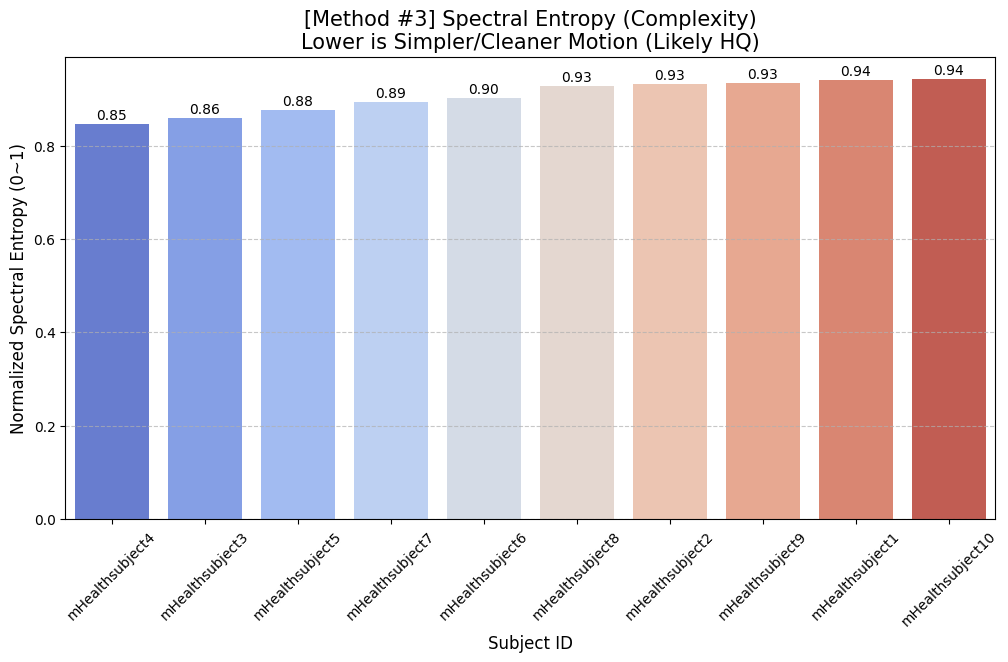


[Selection based on Entropy]
🟢 Cleanest Signal (Lowest Entropy): mHealthsubject4
🔴 Noisiest Signal (Highest Entropy): mHealthsubject10


In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import welch

# =========================================================
# 1. Spectral Entropy 계산 함수
# =========================================================
def calculate_spectral_entropy(df, fs=50):
    # 벡터 크기(VM) 사용
    acc_data = df[['acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z']].values
    vm = np.linalg.norm(acc_data, axis=1)

    # DC 성분(중력) 제거
    vm_centered = vm - np.mean(vm)

    # 1. Power Spectral Density (PSD) 계산 (Welch Method)
    # nperseg: 윈도우 길이 (주파수 해상도 결정)
    freqs, psd = welch(vm_centered, fs=fs, nperseg=fs*2)

    # 2. PSD 정규화 (확률 분포처럼 만들기: 총합이 1이 되도록)
    psd_norm = psd / np.sum(psd)

    # 3. 섀넌 엔트로피(Shannon Entropy) 계산
    # log2(0) 방지를 위해 아주 작은 값(epsilon) 더함
    epsilon = 1e-12
    se = -np.sum(psd_norm * np.log2(psd_norm + epsilon))

    # 4. 정규화 (0 ~ 1 사이 값으로)
    # 주파수 빈(bin)의 개수에 따라 최대 엔트로피가 달라지므로 나눠줌
    se_normalized = se / np.log2(len(psd_norm))

    return se_normalized

# =========================================================
# 2. 전체 피험자 분석
# =========================================================
target_act = 'Knees bending'
prof_results_3 = []

print(f"Calculating Method #3: Spectral Entropy (Target: {target_act})...")

for subj_id, acts in mhealth_data.items():
    if target_act not in acts: continue

    score = calculate_spectral_entropy(acts[target_act])

    prof_results_3.append({
        'Subject': subj_id,
        'Spectral_Entropy': score
    })
    print(f" - {subj_id}: {score:.4f}")

# =========================================================
# 3. 시각화
# =========================================================
# ★ 주의: 여기서는 점수가 '낮을수록' 좋은 데이터(HQ)입니다.
# 그래프 해석 편의를 위해 정렬은 오름차순(좋은 -> 나쁜)으로 하겠습니다.
df_prof3 = pd.DataFrame(prof_results_3).sort_values('Spectral_Entropy', ascending=True)

plt.figure(figsize=(12, 6))
# 색상: 낮을수록(왼쪽) 좋으니까 파란색 -> 높을수록(오른쪽) 나쁘니까 붉은색
sns.barplot(x='Subject', y='Spectral_Entropy', data=df_prof3, palette='coolwarm')

plt.title(f"[Method #3] Spectral Entropy (Complexity)\nLower is Simpler/Cleaner Motion (Likely HQ)", fontsize=15)
plt.xticks(rotation=45)
plt.ylabel('Normalized Spectral Entropy (0~1)', fontsize=12)
plt.xlabel('Subject ID', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(df_prof3['Spectral_Entropy']):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)

plt.show()

print(f"\n[Selection based on Entropy]")
print(f"🟢 Cleanest Signal (Lowest Entropy): {df_prof3.iloc[0]['Subject']}")
print(f"🔴 Noisiest Signal (Highest Entropy): {df_prof3.iloc[-1]['Subject']}")

Calculating Method #4: Kurtosis (Target: Knees bending)...
 - mHealthsubject1: 12.5127
 - mHealthsubject10: 3.9790
 - mHealthsubject2: 28.1156
 - mHealthsubject3: 2.7962
 - mHealthsubject4: 4.5186
 - mHealthsubject5: 4.4750
 - mHealthsubject6: 10.5139
 - mHealthsubject7: 1.1508
 - mHealthsubject8: 44.9257
 - mHealthsubject9: 3.0678


/tmp/ipython-input-2396237605.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Subject', y='Kurtosis_Score', data=df_prof4, palette='Reds_r')


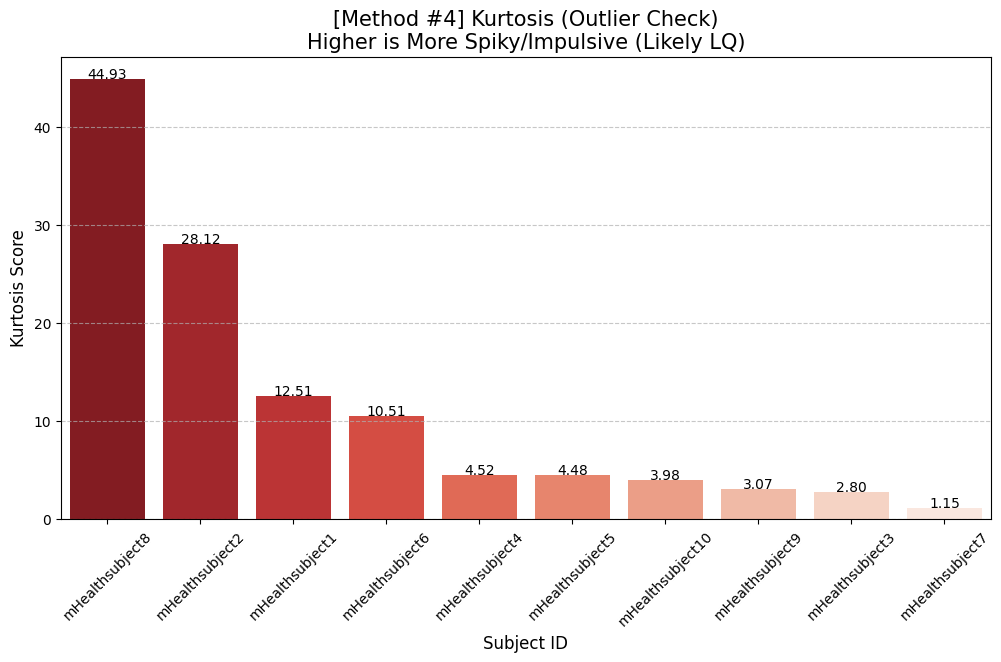


[Selection based on Kurtosis]
🔴 Spiky Signal (Highest Kurtosis): mHealthsubject8
🟢 Smooth Signal (Lowest Kurtosis): mHealthsubject7


In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kurtosis

# =========================================================
# 1. Kurtosis 계산 함수
# =========================================================
def calculate_kurtosis_score(df):
    # 벡터 크기(VM) 사용
    acc_data = df[['acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z']].values
    vm = np.linalg.norm(acc_data, axis=1)

    # Kurtosis 계산 (Fisher's definition: 정규분포 = 0)
    # 값이 아주 클수록 이상치(Spike)가 많다는 뜻
    k_score = kurtosis(vm)

    return k_score

# =========================================================
# 2. 전체 피험자 분석
# =========================================================
target_act = 'Knees bending'
prof_results_4 = []

print(f"Calculating Method #4: Kurtosis (Target: {target_act})...")

for subj_id, acts in mhealth_data.items():
    if target_act not in acts: continue

    score = calculate_kurtosis_score(acts[target_act])

    prof_results_4.append({
        'Subject': subj_id,
        'Kurtosis_Score': score
    })
    print(f" - {subj_id}: {score:.4f}")

# =========================================================
# 3. 시각화
# =========================================================
# ★ 주의: 점수가 '높을수록' 나쁜 데이터(LQ - Spiky/Noisy)입니다.
df_prof4 = pd.DataFrame(prof_results_4).sort_values('Kurtosis_Score', ascending=False)

plt.figure(figsize=(12, 6))
# 색상: 높을수록(왼쪽) 나쁘니까 붉은색 -> 낮을수록(오른쪽) 좋으니까 파란색
sns.barplot(x='Subject', y='Kurtosis_Score', data=df_prof4, palette='Reds_r')

plt.title(f"[Method #4] Kurtosis (Outlier Check)\nHigher is More Spiky/Impulsive (Likely LQ)", fontsize=15)
plt.xticks(rotation=45)
plt.ylabel('Kurtosis Score', fontsize=12)
plt.xlabel('Subject ID', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(df_prof4['Kurtosis_Score']):
    plt.text(i, v + 0.05, f"{v:.2f}", ha='center', fontsize=10)

plt.show()

print(f"\n[Selection based on Kurtosis]")
print(f"🔴 Spiky Signal (Highest Kurtosis): {df_prof4.iloc[0]['Subject']}")
print(f"🟢 Smooth Signal (Lowest Kurtosis): {df_prof4.iloc[-1]['Subject']}")

Calculating Method #5: Inter-sensor Consistency (Target: Knees bending)...
 - mHealthsubject1: 0.2039
 - mHealthsubject10: 0.4914
 - mHealthsubject2: 0.2748
 - mHealthsubject3: 0.1163
 - mHealthsubject4: 0.2082
 - mHealthsubject5: 0.1977
 - mHealthsubject6: 0.0585
 - mHealthsubject7: 0.2449
 - mHealthsubject8: 0.0339
 - mHealthsubject9: 0.3339


/tmp/ipython-input-2167397145.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Subject', y='Consistency_Score', data=df_prof5, palette='Greens_r')


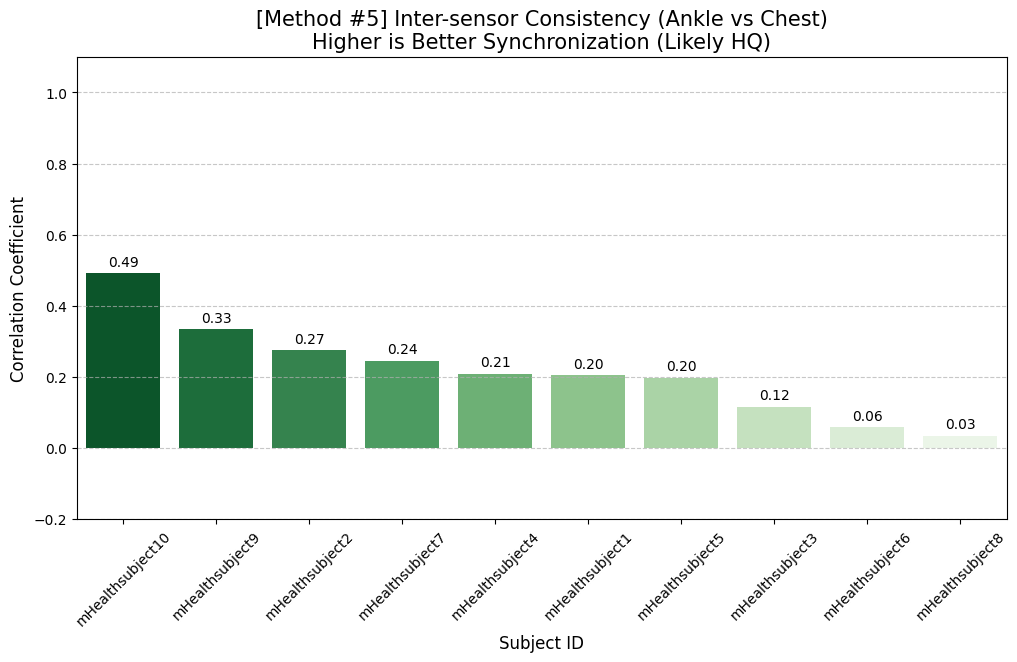


[Selection based on Consistency]
🟢 Best Sync (Highest Corr): mHealthsubject10
🔴 Worst Sync (Lowest Corr): mHealthsubject8


In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# =========================================================
# 1. 일관성(Consistency) 계산 함수
# =========================================================
def calculate_consistency_score(df):
    # 데이터셋에 가슴(chest) 데이터가 있는지 확인
    # (mHealth 데이터셋 컬럼명: acc_chest_x, acc_chest_y, ...)
    required_cols = ['acc_chest_x', 'acc_chest_y', 'acc_chest_z',
                     'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z']

    if not all(col in df.columns for col in required_cols):
        return 0.0 # 데이터 없으면 0점 처리

    # 1. 발목 데이터 크기 (Magnitude)
    acc_ankle = df[['acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z']].values
    vm_ankle = np.linalg.norm(acc_ankle, axis=1)

    # 2. 가슴 데이터 크기 (Magnitude)
    acc_chest = df[['acc_chest_x', 'acc_chest_y', 'acc_chest_z']].values
    vm_chest = np.linalg.norm(acc_chest, axis=1)

    # 3. 피어슨 상관계수 계산
    # [0, 1] 또는 [1, 0] 위치의 값이 두 변수 간의 상관계수
    correlation = np.corrcoef(vm_ankle, vm_chest)[0, 1]

    # 가끔 음수가 나올 수도 있는데(방향 반대),
    # '움직임의 강도' 패턴 자체는 양의 상관관계여야 함.
    return correlation

# =========================================================
# 2. 전체 피험자 분석
# =========================================================
target_act = 'Knees bending'
prof_results_5 = []

print(f"Calculating Method #5: Inter-sensor Consistency (Target: {target_act})...")

for subj_id, acts in mhealth_data.items():
    if target_act not in acts: continue

    score = calculate_consistency_score(acts[target_act])

    prof_results_5.append({
        'Subject': subj_id,
        'Consistency_Score': score
    })
    print(f" - {subj_id}: {score:.4f}")

# =========================================================
# 3. 시각화
# =========================================================
# 점수가 높을수록(1.0에 가까울수록) 좋은 데이터(HQ)
df_prof5 = pd.DataFrame(prof_results_5).sort_values('Consistency_Score', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Subject', y='Consistency_Score', data=df_prof5, palette='Greens_r')
plt.xticks(rotation=45)
plt.title(f"[Method #5] Inter-sensor Consistency (Ankle vs Chest)\nHigher is Better Synchronization (Likely HQ)", fontsize=15)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.xlabel('Subject ID', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(-0.2, 1.1)

for i, v in enumerate(df_prof5['Consistency_Score']):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)

plt.show()

print(f"\n[Selection based on Consistency]")
print(f"🟢 Best Sync (Highest Corr): {df_prof5.iloc[0]['Subject']}")
print(f"🔴 Worst Sync (Lowest Corr): {df_prof5.iloc[-1]['Subject']}")

=== Method Ranking (Top is Best/HQ) ===
         R_Var  R_Auto  R_Ent  R_Kurt  R_Cons  Prof_Rank_Sum
Subject                                                     
S7         8.0     4.0    4.0     1.0     4.0           21.0
S3         5.0     5.0    2.0     2.0     8.0           22.0
S4         4.0     6.0    1.0     6.0     5.0           22.0
S5         2.0     7.0    3.0     5.0     7.0           24.0
S9         9.0     2.0    8.0     3.0     2.0           24.0
S10       10.0     1.0   10.0     4.0     1.0           26.0
S8         3.0     3.0    6.0    10.0    10.0           32.0
S1         1.0    10.0    9.0     8.0     6.0           34.0
S2         6.0     9.0    7.0     9.0     3.0           34.0
S6         7.0     8.0    5.0     7.0     9.0           36.0


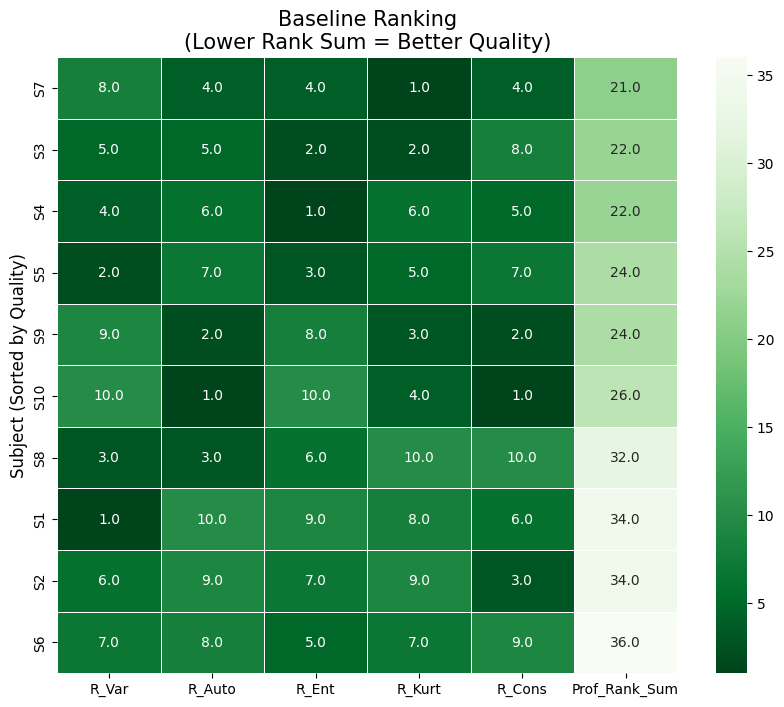


[Conclusion]
🟢 Best (HQ): S7 (Sum: 21.0)
🔴 Worst (LQ): S6 (Sum: 36.0)


In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 교수님 방법 결과 데이터 입력
data_prof = {
    'Subject': ['S1', 'S10', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9'],
    'Variance': [0.7067, 0.1335, 0.3671, 0.3790, 0.4445, 0.5944, 0.3568, 0.2502, 0.4650, 0.1545],
    'AutoCorr': [0.0776, 0.2799, 0.1152, 0.1580, 0.1458, 0.1210, 0.1165, 0.1690, 0.1945, 0.2480],
    'Entropy': [0.9399, 0.9431, 0.9313, 0.8596, 0.8469, 0.8757, 0.9014, 0.8933, 0.9287, 0.9346],
    'Kurtosis': [12.5127, 3.9790, 28.1156, 2.7962, 4.5186, 4.4750, 10.5139, 1.1508, 44.9257, 3.0678],
    'Consistency': [0.2039, 0.4914, 0.2748, 0.1163, 0.2082, 0.1977, 0.0585, 0.2449, 0.0339, 0.3339]
}

df_prof = pd.DataFrame(data_prof).set_index('Subject')

# 2. 랭킹 계산 (1등이 HQ / 가장 좋은 데이터)
# 주의: Rank값이 '낮을수록' 좋은 등수 (1등, 2등...)

# 클수록 좋은 지표들 (Descending) -> 값이 크면 Rank 1
df_prof['R_Var'] = df_prof['Variance'].rank(ascending=False)
df_prof['R_Auto'] = df_prof['AutoCorr'].rank(ascending=False)
df_prof['R_Cons'] = df_prof['Consistency'].rank(ascending=False)

# 작을수록 좋은 지표들 (Ascending) -> 값이 작으면 Rank 1
df_prof['R_Ent'] = df_prof['Entropy'].rank(ascending=True)
df_prof['R_Kurt'] = df_prof['Kurtosis'].rank(ascending=True)

# 3. 종합 점수 (Total Rank Sum)
# 점수가 낮을수록 (1등이 많을수록) 교수님이 보기에 '좋은 데이터(HQ)'
df_prof['Prof_Rank_Sum'] = df_prof['R_Var'] + df_prof['R_Auto'] + df_prof['R_Cons'] + df_prof['R_Ent'] + df_prof['R_Kurt']

# 4. 정렬 (좋은 순서대로 / Rank Sum이 낮은 순서대로)
df_prof_sorted = df_prof.sort_values('Prof_Rank_Sum', ascending=True)

# 5. 출력
print("=== Method Ranking (Top is Best/HQ) ===")
# 보기 편하게 원본 값은 빼고 랭크만 출력
cols = ['R_Var', 'R_Auto', 'R_Ent', 'R_Kurt', 'R_Cons', 'Prof_Rank_Sum']
print(df_prof_sorted[cols])

# 6. 시각화
plt.figure(figsize=(10, 8))
# 교수는 점수가 낮을수록 좋으므로, 색상은 반대로(낮은게 진하게) 하거나
# 직관을 위해 그냥 랭크 숫자 그대로 표시 (낮을수록 Good)
sns.heatmap(df_prof_sorted[cols], annot=True, fmt='.1f', cmap='Greens_r', linewidths=.5)
plt.title("Baseline Ranking\n(Lower Rank Sum = Better Quality)", fontsize=15)
plt.ylabel('Subject (Sorted by Quality)', fontsize=12)
plt.show()

# 7. 결과 비교를 위한 요약
best_prof = df_prof_sorted.index[0]
worst_prof = df_prof_sorted.index[-1]

print(f"\n[Conclusion]")
print(f"🟢 Best (HQ): {best_prof} (Sum: {df_prof_sorted.iloc[0]['Prof_Rank_Sum']})")
print(f"🔴 Worst (LQ): {worst_prof} (Sum: {df_prof_sorted.iloc[-1]['Prof_Rank_Sum']})")